In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'synth1'
abduction        = False
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
n_varsll = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
n_varshl = len(Ghl.nodes())


omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [5]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [6]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [7]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [8]:
def create_psd_matrix(size):
    A = torch.randn(size, size).float()

    return torch.matmul(A, A.T)

# PCA Projection from higher to lower dimension
def pca_projection(Sigma, target_dim):
    """
    Project a d×d matrix to a k×k matrix where k < d
    Args:
        Sigma: source matrix (d×d)
        target_dim: target dimension k
    Returns:
        k×k projected matrix
    """
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(Sigma)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Take only the top target_dim eigenvectors
    V = eigenvectors[:, :target_dim]  # d×k matrix
    
    # Project the covariance matrix
    Sigma_projected = torch.matmul(torch.matmul(V.T, Sigma), V)  # k×k matrix
    
    return Sigma_projected, V

# SVD Projection from higher to lower dimension
def svd_projection(Sigma, target_dim):
    """
    Project a d×d matrix to a k×k matrix where k < d using SVD
    Args:
        Sigma: source matrix (d×d)
        target_dim: target dimension k
    Returns:
        k×k projected matrix
    """
    # Perform SVD
    U, S, V = torch.svd(Sigma)
    
    # Take only the first target_dim components
    U_k = U[:, :target_dim]  # d×k matrix
    S_k = S[:target_dim]     # k singular values
    
    # Project the covariance matrix
    Sigma_projected = torch.matmul(torch.matmul(U_k.T, Sigma), U_k)  # k×k matrix
    
    return Sigma_projected, U_k

def project_covariance(Sigma, n, method):
    if method == 'pca':
        return pca_projection(Sigma, n)
    elif method == 'svd':
        return svd_projection(Sigma, n)
    else:
        raise ValueError(f"Unknown projection method: {method}")
    
def compute_struc_matrices(models, I):
    matrices = []
    for iota in I:
        M_i = torch.from_numpy(models[iota]._compute_reduced_form()).float()  
        matrices.append(M_i)

    return matrices

def compute_mu_bary(struc_matrices, mu):
    struc_matrices_tensor = torch.stack(struc_matrices)
    mu_barycenter         = torch.sum(struc_matrices_tensor @ mu, dim=0) / len(struc_matrices)

    return mu_barycenter

def compute_Sigma_bary(matrices, Sigma, initialization, max_iter, tol):

    Sigma_matrices = []
    for M in matrices:
        Sigma_matrices.append(M @ Sigma @ M.T)

    return covariance_bary_optim(Sigma_matrices, initialization, max_iter, tol)

def covariance_bary_optim(Sigma_list, initialization, max_iter, tol):
    
    if initialization == 'psd':
        S_0 = create_psd_matrix(Sigma_list[0].shape[0])
    elif initialization == 'avg':
        S_0 = sum(Sigma_list) / len(Sigma_list)
    
    S_n = S_0.clone()
    n   = len(Sigma_list)  # Number of matrices
    lambda_j = 1.0 / n   # Equal weights
    
    for n in range(max_iter):
        S_n_old = S_n.clone()

        S_n_inv_half = oput.sqrtm_svd(regmat(torch.inverse(S_n)))
        
        # Compute the sum of S_n^(1/2) Σ_j S_n^(1/2)
        sum_term = torch.zeros_like(S_n)
        for Sigma_j in Sigma_list:
            S_n_half   = oput.sqrtm_svd(regmat(S_n))
            inner_term = torch.matmul(torch.matmul(S_n_half, Sigma_j), S_n_half)
            sqrt_term  = oput.sqrtm_svd(regmat(inner_term))
            sum_term  += lambda_j * sqrt_term
        # Square the sum term
        squared_sum = torch.matmul(sum_term, sum_term.T)

        S_n_next = torch.matmul(torch.matmul(S_n_inv_half, squared_sum), S_n_inv_half)
        S_n = S_n_next

        if torch.norm(S_n - S_n_old, p='fro') < tol:
            #print(f"Converged after {n+1} iterations")
            break
            
    return S_n

def monge(m1, S1, m2, S2):
    inner      = torch.matmul(oput.sqrtm_svd(S1), torch.matmul(S2, oput.sqrtm_svd(S1)))
    sqrt_inner = oput.sqrtm_svd(inner)
    A          = torch.matmul(torch.inverse(oput.sqrtm_svd(regmat(S1))), torch.matmul(sqrt_inner, torch.inverse(oput.sqrtm_svd(regmat(S1)))))  

    # Define the Monge map as a function τ(x) = m_2 + A(x - m_1)
    def tau(x):
        return m2 + A @ (x - m1)

    return tau, A

def regmat(matrix, eps=1e-10):
    # Replace NaN and Inf values with finite numbers
    matrix = torch.nan_to_num(matrix, nan=0.0, posinf=1e10, neginf=-1e10)
    
    # Add a small epsilon to the diagonal for numerical stability
    if matrix.dim() == 2 and matrix.size(0) == matrix.size(1):
        matrix = matrix + eps * torch.eye(matrix.size(0), device=matrix.device)
    
    return matrix


In [9]:
def auto_bary_optim(theta_baryL, theta_baryH, max_iter, tol, seed):

    # Set seeds for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    mu_L, Sigma_L = torch.from_numpy(theta_baryL['mu_U']).float(), torch.from_numpy(theta_baryL['Sigma_U']).float()
    mu_H, Sigma_H = torch.from_numpy(theta_baryH['mu_U']).float(), torch.from_numpy(theta_baryH['Sigma_U']).float()


    T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)

    optimizer_T        = torch.optim.Adam([T], lr=0.001)
    previous_objective = float('inf')
    objective_T        = 0  # Reset objective at the start of each step
    # Optimization loop
    for step in range(max_iter):
        objective_T = 0  # Reset objective at the start of each step
        
        # Calculate each term of the Wasserstein distance
        term1 = torch.norm(T @ mu_L - mu_H) ** 2  # Squared Euclidean distance between transformed means
        term2 = torch.trace(T @ Sigma_L @ T.T)   # Trace term for low-level covariance
        term3 = torch.trace(Sigma_H)             # Trace term for high-level covariance
        
        # Compute the intermediate covariance matrices
        T_Sigma_L_T      = torch.matmul(T, torch.matmul(Sigma_L, T.T))
        T_Sigma_L_T_sqrt = oput.sqrtm_svd(T_Sigma_L_T)
        Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)
        
        # Coupling term using nuclear norm
        term4 = -2 * torch.norm(T_Sigma_L_T_sqrt @ Sigma_H_sqrt, p='nuc')

        # Total objective is the sum of terms
        objective_T += term1 + term2 + term3 + term4

        if abs(previous_objective - objective_T.item()) < tol:
            print(f"Converged at step {step + 1}/{max_iter} with objective: {objective_T.item()}")
            break

        # Update previous objective
        previous_objective = objective_T.item()

        # Perform optimization step
        optimizer_T.zero_grad()  # Clear gradients
        objective_T.backward(retain_graph=True)  # Backpropagate
        optimizer_T.step()  # Update T

    return T  # Return final objective and optimized T

In [10]:
def barycentric_optimization(theta_L, theta_H, LLmodels, HLmodels, Ill, Ihl, projection_method, initialization, autograd, seed, max_iter, tol, display_results):

    # Start timing
    start_time = time.time()

    mu_L, Sigma_L = torch.from_numpy(theta_L['mu_U']).float(), torch.from_numpy(theta_L['Sigma_U']).float()
    mu_H, Sigma_H = torch.from_numpy(theta_H['mu_U']).float(), torch.from_numpy(theta_H['Sigma_U']).float()

    h, l = mu_H.shape[0], mu_L.shape[0]

    # Initialize the structural matrices    
    L_matrices   = compute_struc_matrices(LLmodels, Ill)
    H_matrices   = compute_struc_matrices(HLmodels, Ihl)

    # Initilize the barycenteric means and covariances
    mu_bary_L    = compute_mu_bary(L_matrices, mu_L)
    mu_bary_H    = compute_mu_bary(H_matrices, mu_H)

    Sigma_bary_L = compute_Sigma_bary(L_matrices, Sigma_L, initialization, max_iter, tol)
    Sigma_bary_H = compute_Sigma_bary(H_matrices, Sigma_H, initialization, max_iter, tol)
    
    proj_Sigma_bary_L, Tp = project_covariance(Sigma_bary_L, h, projection_method)
    proj_mu_bary_L        = torch.matmul(Tp.T, mu_bary_L)

    paramsL = {'mu_U': mu_bary_L.detach().numpy(), 'Sigma_U': Sigma_bary_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_bary_H.detach().numpy(), 'Sigma_U': Sigma_bary_H.detach().numpy(), 'radius': delta}

    if autograd == True:
        params_bary_autograd = {
                                'theta_baryL': paramsL,
                                'theta_baryH': paramsH,
                                'max_iter': 10,
                                'tol': 1e-5,
                                'seed': seed
                               }
        
        T = auto_bary_optim(**params_bary_autograd)

    else:
        tau, A = monge(proj_mu_bary_L, proj_Sigma_bary_L, mu_bary_H, Sigma_bary_H)
        T = torch.matmul(A, Tp.T)

    T  = T.detach().numpy()
    Tp = Tp.detach().numpy()

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Display results
    if display_results == True: 
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T

In [11]:
def check_for_invalid_values(matrix):
    if torch.isnan(matrix).any() or torch.isinf(matrix).any():
        #print("Matrix contains NaN or Inf values!")
        return True
    return False

def handle_nans(matrix, replacement_value=0.0):
    # Replace NaNs with a given value (default is 0)
    if torch.isnan(matrix).any():
        print("Warning: NaN values found! Replacing with zero.")
        matrix = torch.nan_to_num(matrix, nan=replacement_value)
    return matrix

In [12]:
def grad_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L):

    term1     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float() 
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float() 

        term1 = term1 + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    term2     = 0#-2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (n+1)) * term1 - term2
    
    return grad_mu_L

def grad_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H):

    term1     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float()  
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float()  

        term1 = term1 + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    term2     = 0#-2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / (n+1)) * term1 - term2

    return grad_mu_H


def grad_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L):

    term1            = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i          = torch.from_numpy(LLmodels[iota].F)
        V_i          = T @ L_i.float()

        term1        = term1 + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    term2            = 0#-2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L     = (2 / (n+1)) * term1 - term2
    
    return grad_Sigma_L

def grad_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H):

    term1            = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i          = torch.from_numpy(HLmodels[omega[iota]].F).float()
        
        term1        = term1 + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2            = 0#-2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H     = (2 / (n+1)) * term1 - term2

    return grad_Sigma_H

def prox_grad_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L):

    Sigma_L               = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()  
        V_i               = oput.regmat(T @ L_i)  
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 
        
        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L).T
        
        ll_term           = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H           = Sigma_H.float()  
        H_Sigma_H         = H_i @ Sigma_H @ H_i.T

        hl_term           = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L           = Sigma_L + (ll_term * hl_term)

    Sigma_L_final         = (2 / (n+1)) * Sigma_L 
    Sigma_L_final         = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def prox_grad_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H):

    Sigma_H               = torch.zeros_like(Sigma_H_half, dtype=torch.float32)
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()
        V_i               = T @ L_i #oput.regmat(T @ L_i)
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()

        Sigma_H_half      = Sigma_H_half.float()
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H)
        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
  
        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H).T
        hl_term_iota      = torch.inverse(H_i) @ prox_Sigma_H_half @ torch.inverse(H_i).T
        
        Sigma_L           = Sigma_L.float()
        V_Sigma_V         = V_i @ Sigma_L @ V_i.T
        ll_term_iota      = torch.norm(oput.sqrtm_svd(V_Sigma_V), p='fro')

        Sigma_H           = Sigma_H + (ll_term_iota * hl_term_iota)
    
    Sigma_H_final         = (2 / (n+1)) * Sigma_H
    Sigma_H_final         = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [13]:
def optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, lambda_L, lambda_H, lambda_param_L, lambda_param_H, eta, num_steps_max, epsilon, delta, seed):
    
    torch.manual_seed(seed)

    cur_T                  = T.clone()
    theta_objectives_epoch = []
    objective_theta_step   = torch.tensor(0.0)
    for _ in range(num_steps_max): 

        mu_L         = mu_L + eta * grad_mu_L(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L)

        mu_H         = mu_H + eta * grad_mu_H(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H)

        Sigma_L_half = Sigma_L + eta * grad_Sigma_L_half(cur_T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L)
        Sigma_L      = prox_grad_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L)

        Sigma_H_half = Sigma_H + eta * grad_Sigma_H_half(cur_T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H)
        Sigma_H      = prox_grad_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
        
        # Project onto Gelbrich balls
        mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        # Verify constraints
        satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        oput.constraints_error_check(satisfied_L, dist_L, epsi, satisfied_H, dist_H, delt)

        objective_iota = 0
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()

            obj_value_iota = oput.compute_objective_value(cur_T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H, 
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            
            objective_iota = objective_iota + obj_value_iota

        objective_theta_step = objective_iota/(n+1)  #+ _**2
        theta_objectives_epoch.append(objective_theta_step)

    return mu_L, Sigma_L, mu_H, Sigma_H, objective_theta_step, theta_objectives_epoch

def optimize_max_proxgrad(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, 
                lambda_L, lambda_H, lambda_param_L, lambda_param_H, eta, num_steps_max, epsilon, delta, seed):
    


    #There might be some issues because the computation of the objective seems to neglect the proximal gradient step!!



    
    torch.manual_seed(seed)
    cur_T   = T.clone()
    # Convert inputs to torch tensors with gradients
    mu_L    = torch.tensor(mu_L, requires_grad=True)
    mu_H    = torch.tensor(mu_H, requires_grad=True)
    Sigma_L = torch.tensor(Sigma_L, requires_grad=True)
    Sigma_H = torch.tensor(Sigma_H, requires_grad=True)
    
    # Create optimizers for means and covariances
    optimizer_mu    = torch.optim.Adam([mu_L, mu_H], lr=eta)
    optimizer_sigma = torch.optim.Adam([Sigma_L, Sigma_H], lr=eta)
    
    theta_objectives_epoch = []
    for _ in range(num_steps_max):
        # Zero gradients
        optimizer_mu.zero_grad()
        optimizer_sigma.zero_grad()
        
        # Compute objective for this step
        # Initialize list to store individual objectives
        obj_values = []
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()
            
            # Compute objective value
            obj_value_iota = oput.compute_objective_value(cur_T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H, 
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            obj_values.append(obj_value_iota)
        
        # Sum objectives without in-place operations
        objective_iota = torch.stack(obj_values).sum()
        
        # Add regularization terms
        reg_mu_L    = lambda_L * torch.sum((mu_L - hat_mu_L) ** 2)
        reg_mu_H    = lambda_H * torch.sum((mu_H - hat_mu_H) ** 2)
        reg_Sigma_L = lambda_L * torch.norm(Sigma_L - hat_Sigma_L, p='fro')
        reg_Sigma_H = lambda_H * torch.norm(Sigma_H - hat_Sigma_H, p='fro')
        
        # Total objective
        objective = -(objective_iota/(n+1)) #+ reg_mu_L + reg_mu_H + reg_Sigma_L + reg_Sigma_H
        
        # Store objective value
        theta_objectives_epoch.append(objective)
        
        # Backward pass
        objective.backward()
        
        # Update means using optimizer
        optimizer_mu.step()
        
        # Store current Sigma values before proximal update
        Sigma_L_half = Sigma_L.detach().clone()
        Sigma_H_half = Sigma_H.detach().clone()
        
        # Update Sigma_half values using optimizer
        optimizer_sigma.step()
        
        # Manual proximal gradient steps for Sigma_L and Sigma_H
        with torch.no_grad():
            # Proximal step for Sigma_L
            Sigma_L = prox_grad_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H_half, HLmodels, lambda_param_L)
            
            # Proximal step for Sigma_H
            Sigma_H = prox_grad_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
            
            # Update the tensor values for next iteration
            Sigma_L.requires_grad_(True)
            Sigma_H.requires_grad_(True)

    
    return (mu_L.detach(), Sigma_L.detach(), mu_H.detach(), Sigma_H.detach(), objective.detach(), theta_objectives_epoch)


def optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta, num_steps_min, optimizer_T, seed, xavier):

    torch.manual_seed(seed)
    if xavier:
        T = torch.nn.init.xavier_normal_(T, gain=0.01)

    cur_mu_L    = mu_L.clone()
    cur_mu_H    = mu_H.clone()
    cur_Sigma_L = Sigma_L.clone()
    cur_Sigma_H = Sigma_H.clone()

    objective_T_step = torch.tensor(0.0)  
    T_objectives_epoch = []
    for step in range(num_steps_min):

        objective_iota = torch.tensor(0.0)        
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()
            
            obj_value_iota   = oput.compute_objective_value(T, L_i, H_i, cur_mu_L, cur_mu_H, cur_Sigma_L, cur_Sigma_H,
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            
            objective_iota = objective_iota + obj_value_iota

        objective_T_step = objective_iota/(n+1)
        T_objectives_epoch.append(objective_T_step)

        if torch.isnan(T).any():
            print("T contains NaN!")
            print('step: ', step+1)

        optimizer_T.zero_grad() 
        objective_T_step.backward(retain_graph=True)
        optimizer_T.step()  
        #print(f"Min step {step+1}/{num_steps_min}, Objective: {objective_T.item()}, Gradient: {T.grad}")
    
    return T, objective_T_step, T_objectives_epoch


### ERICA EXPERIMENTATION

In [14]:
def run_optimization(theta_hatL, theta_hatH, initial_theta,
                     epsilon, delta, lambda_L, lambda_H, lambda_param_L, lambda_param_H, 
                     eta_min, eta_max, max_iter, num_steps_min, num_steps_max, proximal_grad,
                     tol, seed, robust_L, robust_H, plot_steps, plot_epochs, display_results):
    
    torch.manual_seed(seed) 

    # Start timing
    start_time = time.time()
    erica      = robust_L or robust_H
    
    mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H = oput.get_initialization(theta_hatL, theta_hatH, epsilon, delta, initial_theta)

    T           = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
    
    previous_objective = float('inf') 
    epoch_objectives   = {'T_objectives_overall': [], 'theta_objectives_overall': []}
    for epoch in tqdm(range(max_iter)): 
        
        inner_loop_objectives = {'min_objectives': [], 'max_objectives': []}
        
        # Minimize T
        T_new, objective_T, T_objectives_epoch = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                              lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta, num_steps_min, optimizer_T, seed, xavier=False)
        #print(f"epoch: {epoch+1}, objective_T: {objective_T}")
        # Store objective
        inner_loop_objectives['min_objectives'] = T_objectives_epoch
        epoch_objectives['T_objectives_overall'].append(objective_T)

        # Maximize μ, Σ
        if erica:                                                                  
            if proximal_grad:
                mu_L, Sigma_L, mu_H, Sigma_H, obj_theta, theta_objectives_epoch = optimize_max_proxgrad(T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                                        lambda_L, lambda_H, lambda_param_L, lambda_param_H,
                                                                                                        eta_max, num_steps_max, epsilon, delta, seed
                                                                                                        )
            else:
                mu_L, Sigma_L, mu_H, Sigma_H, obj_theta, theta_objectives_epoch = optimize_max(
                                                                                                T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                                                hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                                lambda_L, lambda_H, lambda_param_L, lambda_param_H,
                                                                                                eta_max, num_steps_max, epsilon, delta, seed
                                                                                              )
            
            # Store objectives
            inner_loop_objectives['max_objectives'] = theta_objectives_epoch
            epoch_objectives['theta_objectives_overall'].append(obj_theta)
    
        if plot_steps:
            oput.plot_inner_loop_objectives(inner_loop_objectives, epoch, erica)
        
        # Check convergence
        criterion = abs(previous_objective - objective_T.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break

        T                  = T_new
        previous_objective = objective_T.item()

    if plot_epochs:
        oput.plot_epoch_objectives(epoch_objectives, erica)

    paramsL      = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH      = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}
    T            = T.detach().numpy()
    end_time     = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, inner_loop_objectives, epoch_objectives

In [15]:
theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

seed = 23

  0%|          | 0/5 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

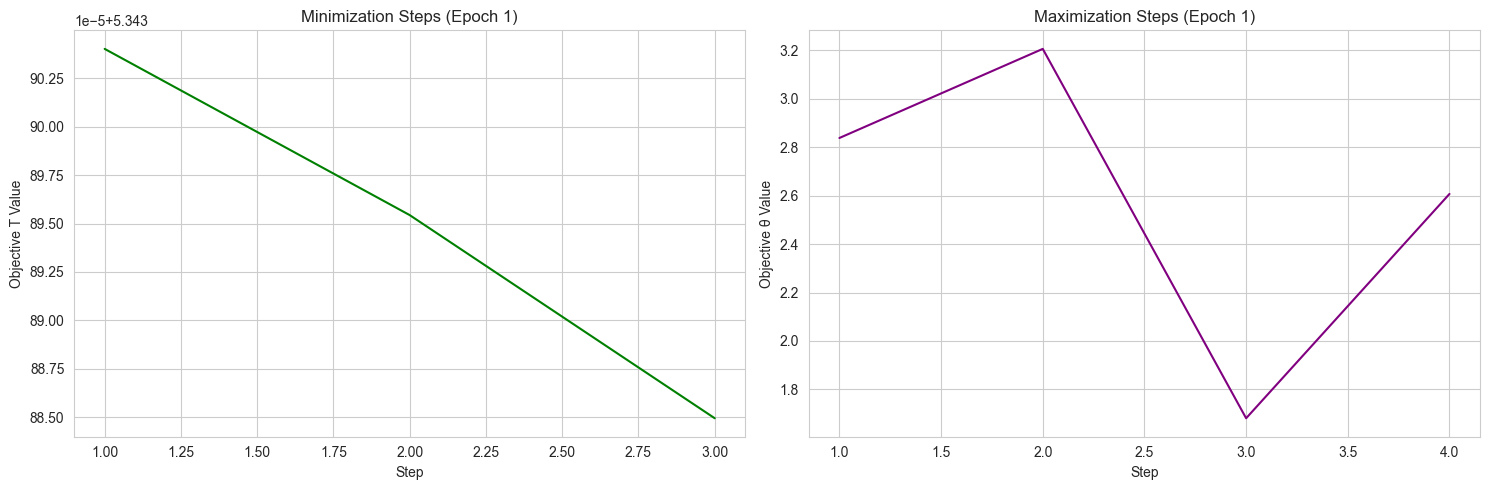

 20%|██        | 1/5 [00:00<00:02,  1.72it/s]

<Figure size 1000x600 with 0 Axes>

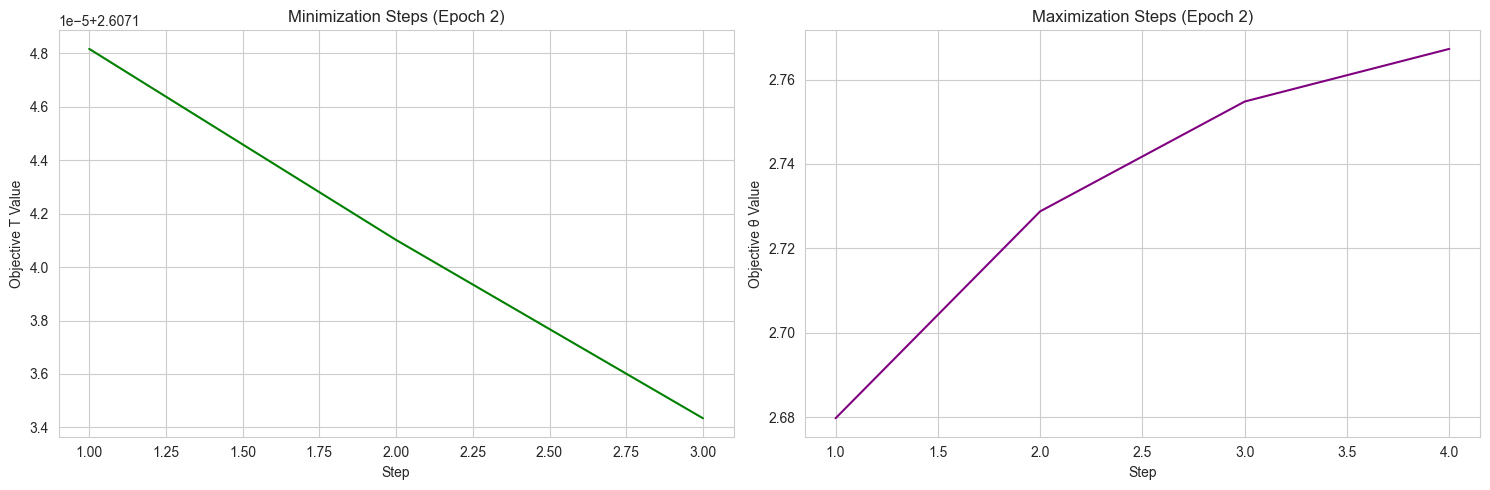

 40%|████      | 2/5 [00:01<00:01,  1.56it/s]

<Figure size 1000x600 with 0 Axes>

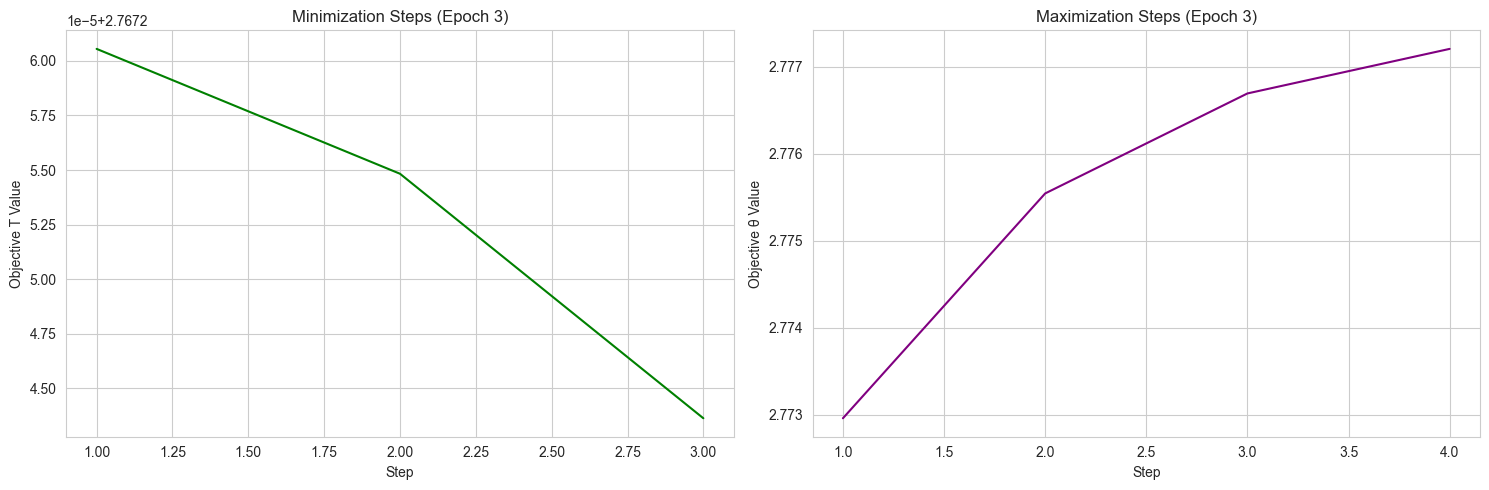

 60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

<Figure size 1000x600 with 0 Axes>

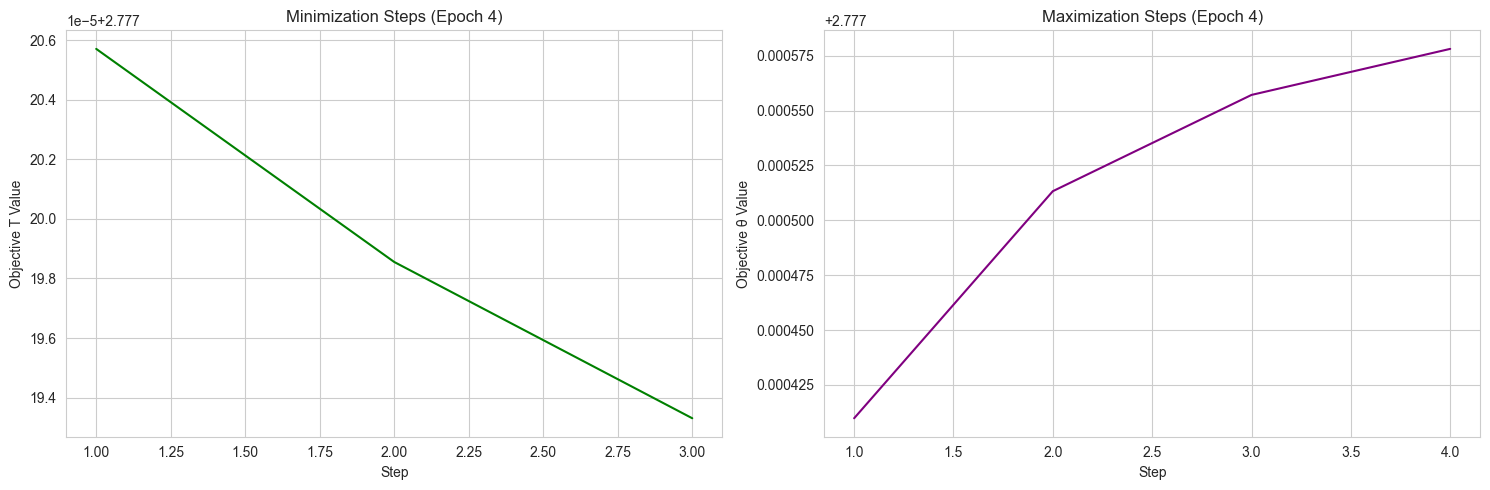

 80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

<Figure size 1000x600 with 0 Axes>

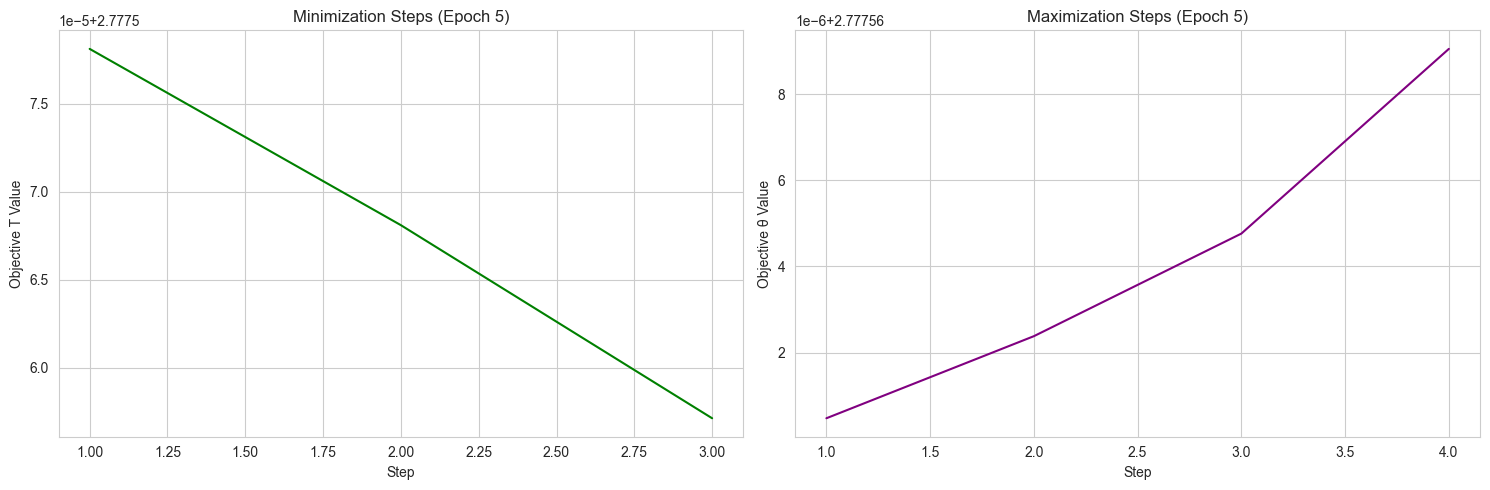

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


In [18]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': .9,
                    'delta': .8,
                    'lambda_L': .3,
                    'lambda_H': .6,
                    'lambda_param_L': .3, # when high monotonic increase for seed 42
                    'lambda_param_H': .2,
                    'eta_max': 0.00001,
                    'eta_min': 0.000001,
                    'max_iter': 5,
                    'num_steps_min': 3,
                    'num_steps_max': 4,
                    'proximal_grad': False,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': False,
                    'plot_steps': True,
                    'plot_epochs': False,
                    'display_results': False
                }

params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs = run_optimization(**params_erica)

In [17]:
# params_erica =  {
#                     'theta_hatL': theta_hatL,
#                     'theta_hatH': theta_hatH,
#                     'initial_theta': 'empirical',
#                     'epsilon': 10,
#                     'delta': 20,
#                     'lambda_L': 10,
#                     'lambda_H': 15,
#                     'lambda_param_L': .3, # when high monotonic increase for seed 42
#                     'lambda_param_H': .2,
#                     'eta_max': 0.00001,
#                     'eta_min': 0.000001,
#                     'max_iter': 5,
#                     'num_steps_min': 3,
#                     'num_steps_max': 4,
#                     'proximal_grad': True,
#                     'tol': 1e-5,
#                     'seed': seed,
#                     'robust_L': True,
#                     'robust_H': True,
#                     'plot_steps': False,
#                     'plot_epochs': False,
#                     'display_results': False
#                 }

# params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs = run_optimization(**params_erica)

In [18]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': .9,
                    'delta': .8,
                    'lambda_L': .9,
                    'lambda_H': .8,
                    'lambda_param_L': .3, # when high monotonic increase for seed 42
                    'lambda_param_H': .2,
                    'eta_max': 0.00001,
                    'eta_min': 0.000001,
                    'max_iter': 5,
                    'num_steps_min': 3,
                    'num_steps_max': 4,
                    'proximal_grad': False,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': True,
                    'robust_H': True,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': False
                }

params_Lerica, params_Herica, T_erica, inobjs, epobjs = run_optimization(**params_erica)

  0%|          | 0/5 [00:00<?, ?it/s]

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 109.87861633300781
Min step: 2, Objective: 109.87855529785156
Min step: 3, Objective: 109.87846374511719



 20%|██        | 1/5 [00:00<00:01,  2.25it/s]

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 82.63712310791016
Min step: 2, Objective: 82.63703918457031
Min step: 3, Objective: 82.63694763183594



 40%|████      | 2/5 [00:01<00:02,  1.28it/s]

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 82.63728332519531
Min step: 2, Objective: 82.63719940185547
Min step: 3, Objective: 82.63712310791016



 60%|██████    | 3/5 [00:02<00:02,  1.04s/it]

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 82.63703918457031
Min step: 2, Objective: 82.63697814941406
Min step: 3, Objective: 82.63690185546875



 80%|████████  | 4/5 [00:04<00:01,  1.38s/it]

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 82.63679504394531
Min step: 2, Objective: 82.63671875
Min step: 3, Objective: 82.63665771484375



100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


### ENRiCO Minimization (works) do not delete!

In [19]:
# def run_enrico_optimization_min(theta_hatL, theta_hatH, initial_theta,
#                                 epsilon, delta, lambda_L, lambda_H, lambda_param, 
#                                 eta_min, eta_max, max_iter, num_steps_min, num_steps_max,
#                                 tol, seed, robust, plot_steps, plot_epochs, display_results):
    
#     # Start timing
#     start_time = time.time()

#     torch.manual_seed(seed) 
#     torch.cuda.manual_seed_all(seed)

#     hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
#     hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

#     if initial_theta == 'gelbrich':
#         l = hat_mu_L.shape[0]
#         h = hat_mu_H.shape[0]

#         # Gelbrich initialization
#         ll_moments    = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
#         mu_L, Sigma_L = ll_moments[0]
#         mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

#         hl_moments    = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
#         mu_H, Sigma_H = hl_moments[0]
#         mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()

#     elif initial_theta == 'empirical':
#         mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
#         mu_H, Sigma_H = hat_mu_H, hat_Sigma_H
    
#     # Initialize storage
#     T_objectives = []

#     T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
#     #T = torch.from_numpy(Tau).float()
#     #optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
#     optimizer_T = torch.optim.SGD([T], lr=eta_min, momentum=0.9)
#     previous_objective = float('inf')  
#     objective_T        = torch.tensor(0.0)
#     for epoch in tqdm(range(max_iter)): 
            
#         objective_T_step = torch.tensor(0.0) #torch.tensor(0.0) # Reset objective at the start of each step
#         for n, iota in enumerate(Ill):
#             L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()
#             H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
            
#             obj_value_iota = oput.compute_objective_value(T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H,
#                                                           lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
#                                                           epsilon, delta)
            
#             objective_T_step = objective_T_step + obj_value_iota
        
#         objective_T = objective_T_step/(n+1)

#         T_objectives.append(objective_T.item())

#         if torch.isnan(T).any():
#             print("Gradient contains NaN!")
#             print('step: ', epoch+1)

#         optimizer_T.zero_grad() 
#         objective_T.backward(retain_graph=True)
#         optimizer_T.step()  

#         # Check convergence
#         criterion = abs(previous_objective - objective_T.item()) 
#         if criterion < tol:
#             print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
#             break

#         previous_objective = objective_T.item()

#     # Plot overall progress
#     # if plot_epochs == True:
#     #     oput.plot_overall_progress(T_objectives, robust)

#     paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
#     paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

#     T = T.detach().numpy()
    
#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     if display_results == True:
#         oput.print_results(T, paramsL, paramsH, elapsed_time)

#     return paramsL, paramsH, T, T_objectives

#def plot_overall_progress(objectives_list, robust=False):
#     """
#     Plot objective values over epochs from a simple list.
    
#     Args:
#         objectives_list: List of objective values per epoch
#         robust: Boolean flag (not used in this simplified version)
#     """
#     plt.figure(figsize=(10, 6))
    
#     # Create x-axis values (epoch numbers)
#     epochs = range(1, len(objectives_list) + 1)
    
#     # Plot the objectives
#     sns.lineplot(
#         x=epochs,
#         y=objectives_list,
#         color='blue',
#         label='Objective'
#     )
    
#     plt.title('Optimization Progress')
#     plt.xlabel('Epoch')
#     plt.ylabel('Objective Value')
#     plt.grid(True, alpha=0.3)
    
#     # Add markers to better see individual points
#     plt.scatter(epochs, objectives_list, color='blue', alpha=0.5, s=30)
    
#     # Scientific notation for y-axis if values are very small/large
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
#     plt.tight_layout()
#     plt.show()

In [20]:
# params_enrico_min =  {
#                     'theta_hatL': theta_hatL,
#                     'theta_hatH': theta_hatH,
#                     'initial_theta': 'empirical',
#                     'epsilon': .9,
#                     'delta': .8,
#                     'lambda_L': 0.9,
#                     'lambda_H': 0.9,
#                     'lambda_param': 0.9,
#                     'eta_max': 0.001,
#                     'eta_min': 0.001,
#                     'max_iter': 1000,
#                     'num_steps_min': 4,
#                     'num_steps_max': 3,
#                     'tol': 1e-6,
#                     'seed': seed,
#                     'robust': True,
#                     'plot_steps': True,
#                     'plot_epochs': True,
#                     'display_results': False
#                 }

# params_Lenrico, params_Henrico, T_enrico, objs = run_enrico_optimization_min(**params_enrico_min)
# plot_overall_progress(objs)

### 1. ERICA optimization

In [21]:
type_to_params = {
                     'gelbrich_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     },
                     
                     'boundary_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     }
                 }

joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

['data/little_lucas/type_to_params.pkl']

### 2. ENRiCO optimization

In [22]:
params_enrico =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': .9,
                    'delta': .8,
                    'lambda_L': .9,
                    'lambda_H': .8,
                    'lambda_param_L': .3, # when high monotonic increase for seed 42
                    'lambda_param_H': .2,
                    'eta_max': 0.00001,
                    'eta_min': 0.000001,
                    'max_iter': 5,
                    'num_steps_min': 3,
                    'num_steps_max': 4,
                    'proximal_grad': False,
                    'tol': 1e-5,
                    'seed': seed,
                    'robust_L': False,
                    'robust_H': False,
                    'plot_steps': False,
                    'plot_epochs': False,
                    'display_results': False
                }

params_Lenrico, params_Henrico, T_enrico, inobjs, epobjs = run_optimization(**params_enrico)

 20%|██        | 1/5 [00:00<00:00,  8.53it/s]

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 109.87861633300781
Min step: 2, Objective: 109.87855529785156
Min step: 3, Objective: 109.87846374511719

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 109.87840270996094
Min step: 2, Objective: 109.87833404541016


 60%|██████    | 3/5 [00:00<00:00,  8.75it/s]

Min step: 3, Objective: 109.87825012207031

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4260,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 109.87815856933594
Min step: 2, Objective: 109.87811279296875
Min step: 3, Objective: 109.8780288696289

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4261,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 109.87794494628906
Min step: 2, Objective: 109.87788391113281


100%|██████████| 5/5 [00:00<00:00,  8.78it/s]

Min step: 3, Objective: 109.8777847290039

current T: tensor([[-0.9012,  0.5656,  0.9096,  0.4261,  1.2886, -0.1708],
        [-0.8564, -0.6576, -0.7005, -0.0962, -0.6191, -0.6317],
        [-0.5774,  0.5874,  0.1230,  0.0885,  1.0446, -0.1837]],
       requires_grad=True)
Min step: 1, Objective: 109.87772369384766
Min step: 2, Objective: 109.87763977050781
Min step: 3, Objective: 109.8775634765625



## 3. Barycentric optimization

### a.  Monge

In [23]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': 'svd',
                'initialization': 'avg',
                'autograd': False,
                'seed': seed,
                'max_iter': 35,
                'tol': 1e-6,
                'display_results': False
                }

params_Lbary, params_Hbary, T_bary = barycentric_optimization(**params_bary)

### b.  Autograd

In [24]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': 'svd',
                'initialization': 'avg',
                'autograd': True,
                'seed': seed,
                'max_iter': 35,
                'tol': 1e-6,
                'display_results': False
                }

params_Lbary, params_Hbary, T_bary_auto = barycentric_optimization(**params_bary)

In [25]:
print('T_erica condition number = ', oput.condition_number(T_erica))
print('T_erica_prox condition number = ', oput.condition_number(T_erica_prox))
print('T_enrico condition number = ', oput.condition_number(T_enrico))
print('T_bary condition number = ', oput.condition_number(T_bary))
print('T_bary_auto condition number = ', oput.condition_number(T_bary_auto))
print('Ground truth Tau condition number = ', oput.condition_number(Tau))

T_erica condition number =  4.894555
T_erica_prox condition number =  4.8945994
T_enrico condition number =  4.894628
T_bary condition number =  6.582694
T_bary_auto condition number =  4.813386
Ground truth Tau condition number =  3.752295770783741


## Run Evaluation

In [26]:
data = mut.load_samples(experiment)

In [27]:
add_noiseL         = True
add_noiseH         = True
noise_typeL        = 'gelbrich_gaussian'
noise_typeH        = 'gelbrich_gaussian'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'multiplicative'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'wass'
num_iter           = 10

100%|██████████| 10/10 [02:00<00:00, 12.07s/it]


Average e(τ) for T_erica: 76.13 ± 0.318 



100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


Average e(τ) for T_erica_prox: 76.08 ± 0.189 



100%|██████████| 10/10 [02:00<00:00, 12.10s/it]


Average e(τ) for T_enrico: 76.18 ± 0.268 



100%|██████████| 10/10 [01:55<00:00, 11.58s/it]


Average e(τ) for T_bary: 69.31 ± 2.491 



100%|██████████| 10/10 [02:01<00:00, 12.15s/it]


Average e(τ) for T_bary_auto: 76.00 ± 0.171 



100%|██████████| 10/10 [01:58<00:00, 11.90s/it]


Average e(τ) for Ground Truth T: 66.35 ± 1.250 



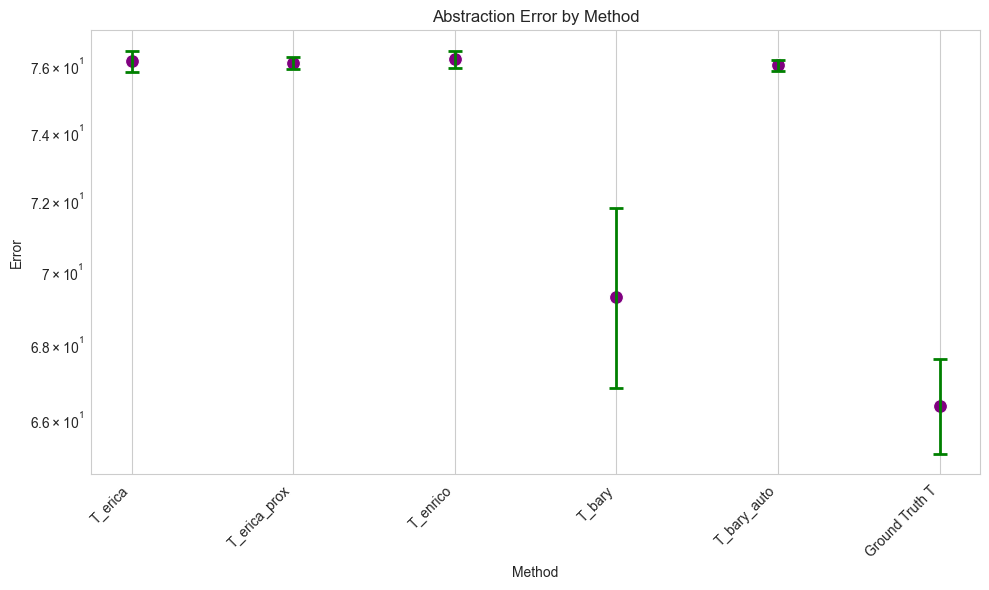

In [28]:
T_name            = ['T_erica','T_erica_prox', 'T_enrico', 'T_bary', 'T_bary_auto', 'Ground Truth T']
abstraction_error = {}
for i, T in enumerate([T_erica, T_erica_prox, T_enrico, T_bary, T_bary_auto, Tau]): 
    all_errors = []  
    avg_error = 0
    
    for _ in tqdm(range(num_iter)):
        total = 0
        for iota in Ill:
            base, abst = data[iota]

            if add_noiseL == True:
                base = evut.add_random_noise(base, noise_typeL, 'L', experiment, normalize=True)

            if add_noiseH == True:
                abst = evut.add_random_noise(abst, noise_typeH, 'H', experiment, normalize=True)

            if lin_contaminationL == True:
                base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)

            if lin_contaminationH == True:
                abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)

            tau_base = base@T.T

            tau_muL    = np.mean(tau_base, axis=0)
            tau_sigmaL = np.cov(tau_base, rowvar=False)
            muH        = np.mean(abst, axis=0)
            sigmaH     = np.cov(abst, rowvar=False)

            if metric == 'wass':
                dist  = mut.compute_wasserstein(tau_muL, tau_sigmaL, muH, sigmaH)
                # tau_gaussian  = mut.sample_distros_Gelbrich([(tau_muL, tau_sigmaL)])[0] 
                # abst_gaussian = mut.sample_distros_Gelbrich([(muH, sigmaH)])[0] 
                # dist = mut.wasserstein_dist(tau_gaussian, abst_gaussian)
            
            elif metric == 'js':
                dist = mut.compute_jensenshannon(tau_base, abst)
            
            #tot_moms += dist 
            total += dist 
            
        iter_avg_ = total/len(Ill)
        all_errors.append(iter_avg_)  
 
    mean_e = np.mean(all_errors)
    std_e = np.std(all_errors)
    abstraction_error[T_name[i]] = (mean_e, std_e*1.96)
    print(f"Average e(τ) for {T_name[i]}: {mean_e:.2f} ± {std_e*1.96:.3f} \n") 

evut.plot_abstraction_error(abstraction_error)

### Plot Gaussian shift effects

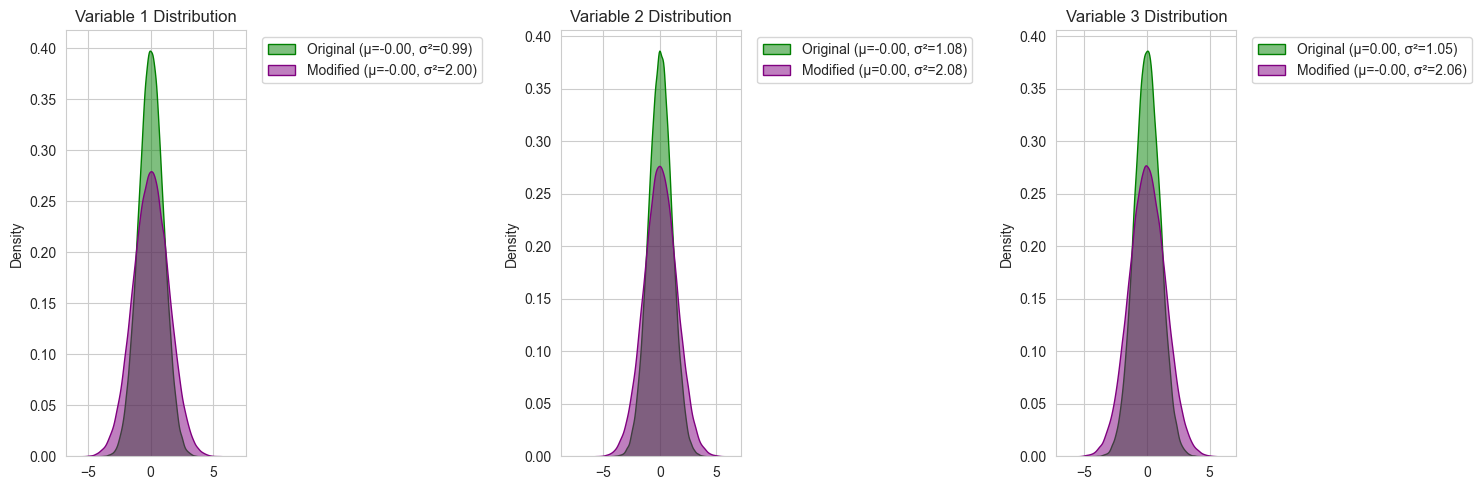

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


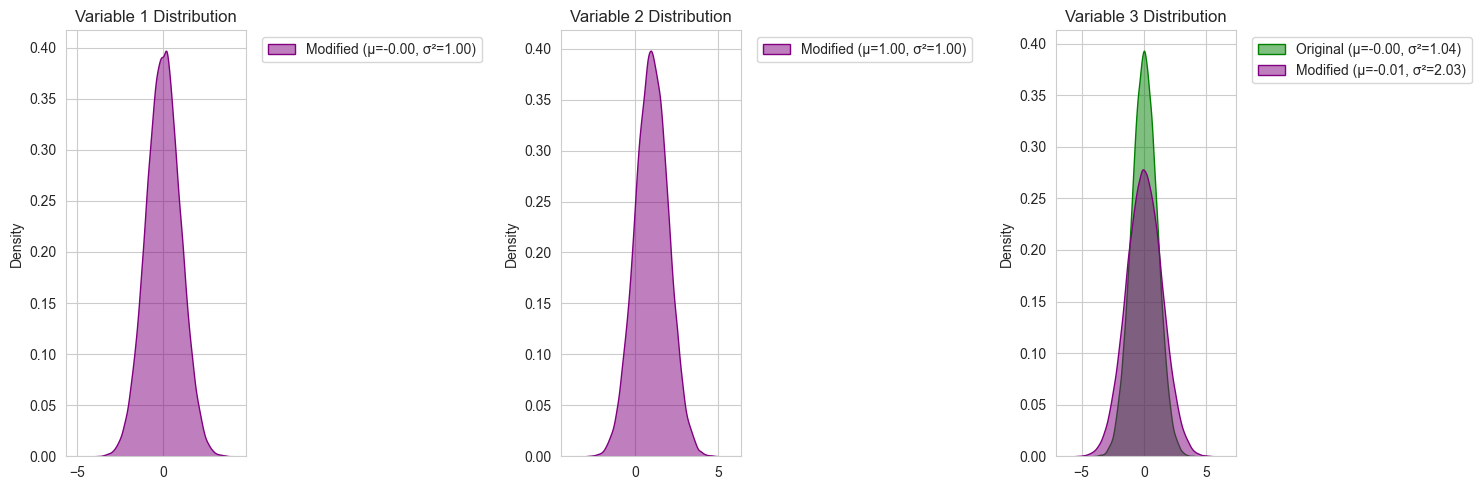

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


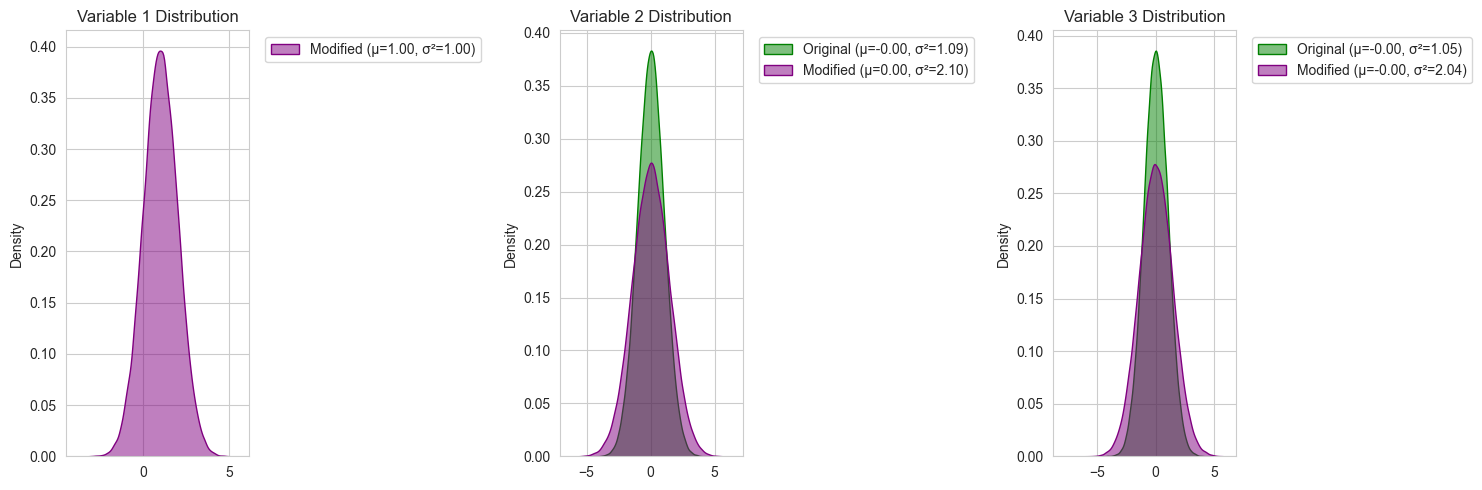

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


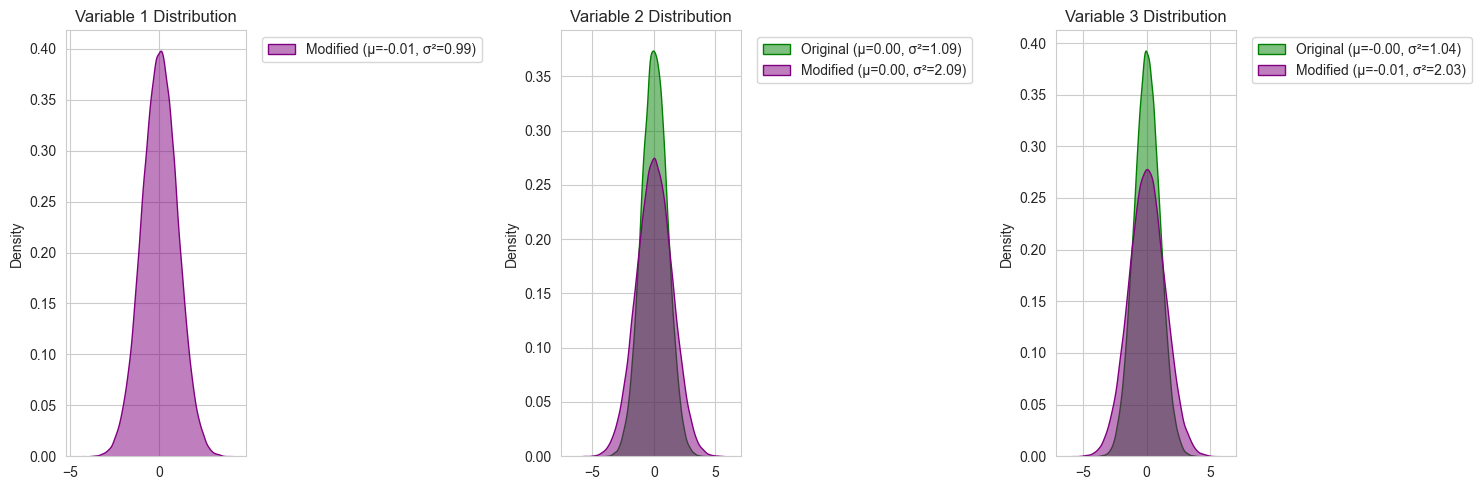

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


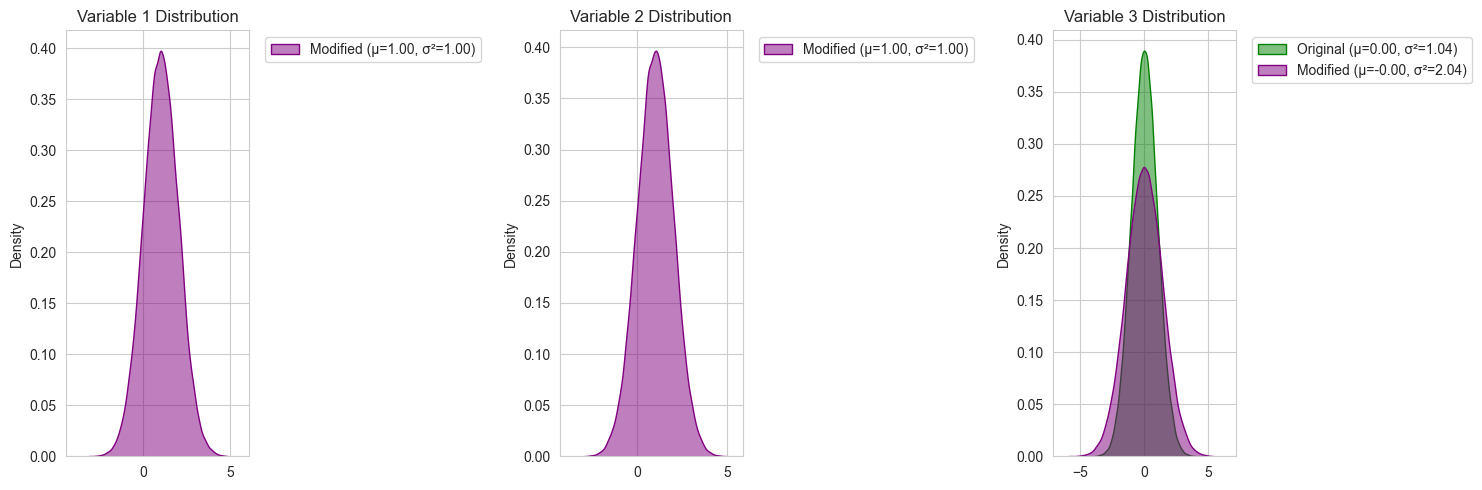

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


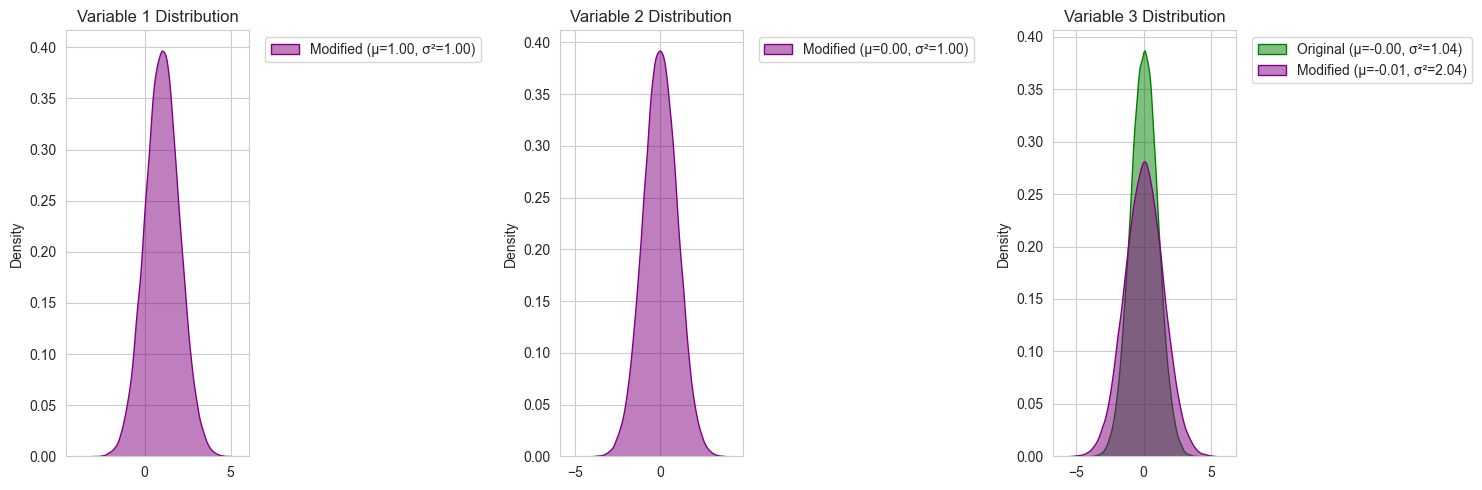

In [43]:
for iota in Ill:
    base, abst = data[iota]
    noisy_base = evut.add_random_noise(base, noise_typeL, 'L')
    evut.plot_distribution_shifts(base, noisy_base)#, f"Base Level Gaussian Shift - {noise_typeL}")
    print( )

### Plot Noise addition and linear contamination effects


In [37]:
for iota in Ill:
    base, abst = data[iota]
    #Add noise
    # base = evut.add_random_noise(base, noise_typeL, 'L')
    # abst = evut.add_random_noise(abst, noise_typeH, 'H')

    #Linear contamination
    base_c = evut.contaminate_linear_relationships(base, contamination_fraction=1, contamination_type='multiplicative')
    #abst_c = evut.contaminate_linear_relationships(abst, contamination_fraction=1, contamination_type='multiplicative')

    evut.plot_contamination_effects(base, base_c)
    print( )


## Structurally generated Gaussians

In [39]:
for i, T in enumerate([T_erica, T_enrico, T_bary, T_bary_auto, Tau]): 
    all_errors = []  
    avg_error = 0
    
    for _ in range(num_iter):
        total = 0
        for iota in Ill:
            L_i = LLmodels[iota]._compute_reduced_form()
            V_i = T @ L_i
            H_i = HLmodels[omega[iota]]._compute_reduced_form()
            muV    = V_i @ params_Lerica['mu_U']
            sigmaV = V_i @ params_Lerica['Sigma_U'] @ V_i.T
            muH    = H_i @ params_Herica['mu_U']
            sigmaH = H_i @ params_Herica['Sigma_U'] @ H_i.T

            dist = mut.compute_wasserstein(muV, sigmaV, muH, sigmaH)

            total += dist

        iter_avg_ = total/len(Ill)
        all_errors.append(iter_avg_)  
 
    mean_e = np.mean(all_errors)
    std_e  = np.std(all_errors)
    print(f"Average e(τ) for {T_name[i]}: {mean_e:.6f} ± {std_e*1.96:.5f}")  